In [1]:
!pip install transformers

In [2]:
import time
import random
import pandas as pd
from glob import glob
import argparse
import json
import subprocess
import sys
import os
import tensorflow as tf
from transformers import DistilBertTokenizer
from transformers import TFDistilBertForSequenceClassification
from transformers import DistilBertConfig

2024-01-12 04:35:18.547351: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# Define the connection between Input data and Label

In [4]:
def select_data_and_label_from_record(record):
    x = {
        "input_ids": record["input_ids"],
        "input_mask": record["input_mask"],
    }
    y = record["label_ids"]

    return (x, y)

In [5]:
def file_based_input_dataset_builder(channel, input_filenames, max_seq_length, is_training, drop_remainder):
    # トレーニング時には並列読み出しとシャッフルを行う。
    # 評価時にはシャッフルは行わず、並列読み出しは効果がない。

    dataset = tf.data.TFRecordDataset(input_filenames)
    dataset = dataset.repeat(100)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

    name_to_features = {
        "input_ids": tf.io.FixedLenFeature([max_seq_length], tf.int64),
        "input_mask": tf.io.FixedLenFeature([max_seq_length], tf.int64),
        "label_ids": tf.io.FixedLenFeature([], tf.int64),
    }

    def _decode_record(record, name_to_features):
        """Decodes a record to a TensorFlow example."""
        return tf.io.parse_single_example(record, name_to_features)

    dataset = dataset.apply(
        tf.data.experimental.map_and_batch(
            lambda record: _decode_record(record, name_to_features),
            batch_size=8,
            drop_remainder=drop_remainder,
            num_parallel_calls=tf.data.experimental.AUTOTUNE,
        )
    )

    dataset.cache()

    if is_training:
        dataset = dataset.shuffle(seed=42, buffer_size=10, reshuffle_each_iteration=True)

    return dataset

In [6]:
# train_data = "./data-tfrecord/bert-train"
train_data_filenames = "/mnt/train_data.tfrecord"
print("train_data_filenames {}".format(train_data_filenames))

train_dataset = file_based_input_dataset_builder(
    channel="train", 
    input_filenames=train_data_filenames, 
    max_seq_length=64, 
    is_training=True, 
    drop_remainder=False
).map(select_data_and_label_from_record)

train_data_filenames /mnt/train_data.tfrecord


2024-01-12 04:35:29.417792: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:1013] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-12 04:35:29.431903: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:1013] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-12 04:35:29.432118: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:1013] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/s

Instructions for updating:
Use `tf.data.Dataset.map(map_func, num_parallel_calls)` followed by `tf.data.Dataset.batch(batch_size, drop_remainder)`. Static tf.data optimizations will take care of using the fused implementation.


In [7]:
print(train_dataset)

<_MapDataset element_spec=({'input_ids': TensorSpec(shape=(None, 64), dtype=tf.int64, name=None), 'input_mask': TensorSpec(shape=(None, 64), dtype=tf.int64, name=None)}, TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


In [8]:
# validation_data = "./data-tfrecord/bert-validation"
validation_data_filenames = "/mnt/validation_data.tfrecord"
print("validation_data_filenames {}".format(validation_data_filenames))

validation_dataset = file_based_input_dataset_builder(
    channel="validation",
    input_filenames=validation_data_filenames,
    max_seq_length=64,
    is_training=False,
    drop_remainder=False,
).map(select_data_and_label_from_record)

validation_data_filenames /mnt/validation_data.tfrecord


In [9]:
epochs = 1
steps_per_epoch = 1
validation_steps = 1
test_steps = 1
freeze_bert_layer = True
learning_rate = 3e-5
epsilon = 1e-08
max_seq_length = 64

In [10]:
CLASSES = [1, 2, 3, 4, 5]

config = DistilBertConfig.from_pretrained(
    "distilbert-base-uncased",
    num_labels=len(CLASSES),
    id2label={0: 1, 1: 2, 2: 3, 3: 4, 4: 5},
    label2id={1: 0, 2: 1, 3: 2, 4: 3, 5: 4},
)
print(config)

DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": 1,
    "1": 2,
    "2": 3,
    "3": 4,
    "4": 5
  },
  "initializer_range": 0.02,
  "label2id": {
    "1": 0,
    "2": 1,
    "3": 2,
    "4": 3,
    "5": 4
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.36.2",
  "vocab_size": 30522
}



In [11]:
# Adding the layer for fine tuning on BERT

In [12]:
transformer_model = TFDistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", config=config)

input_ids = tf.keras.layers.Input(shape=(max_seq_length,), name="input_ids", dtype="int32")
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), name="input_mask", dtype="int32")

embedding_layer = transformer_model.distilbert(input_ids, attention_mask=input_mask)[0]
X = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(
    embedding_layer
)
X = tf.keras.layers.GlobalMaxPool1D()(X)
X = tf.keras.layers.Dense(50, activation="relu")(X)
X = tf.keras.layers.Dropout(0.2)(X)
X = tf.keras.layers.Dense(len(CLASSES), activation="softmax")(X)

model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=X)

for layer in model.layers[:3]:
    layer.trainable = not freeze_bert_layer

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [13]:
# Set up the custom classifier model

In [14]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

metric = tf.keras.metrics.SparseCategoricalAccuracy("accuracy")

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, epsilon=epsilon)

model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 64)]         0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 64)]         0           []                               
                                                                                                  
 distilbert (TFDistilBertMainLa  TFBaseModelOutput(l  66362880   ['input_ids[0][0]',              
 yer)                           ast_hidden_state=(N               'input_mask[0][0]']             
                                one, 64, 768),                                                    
                                 hidden_states=None                                           

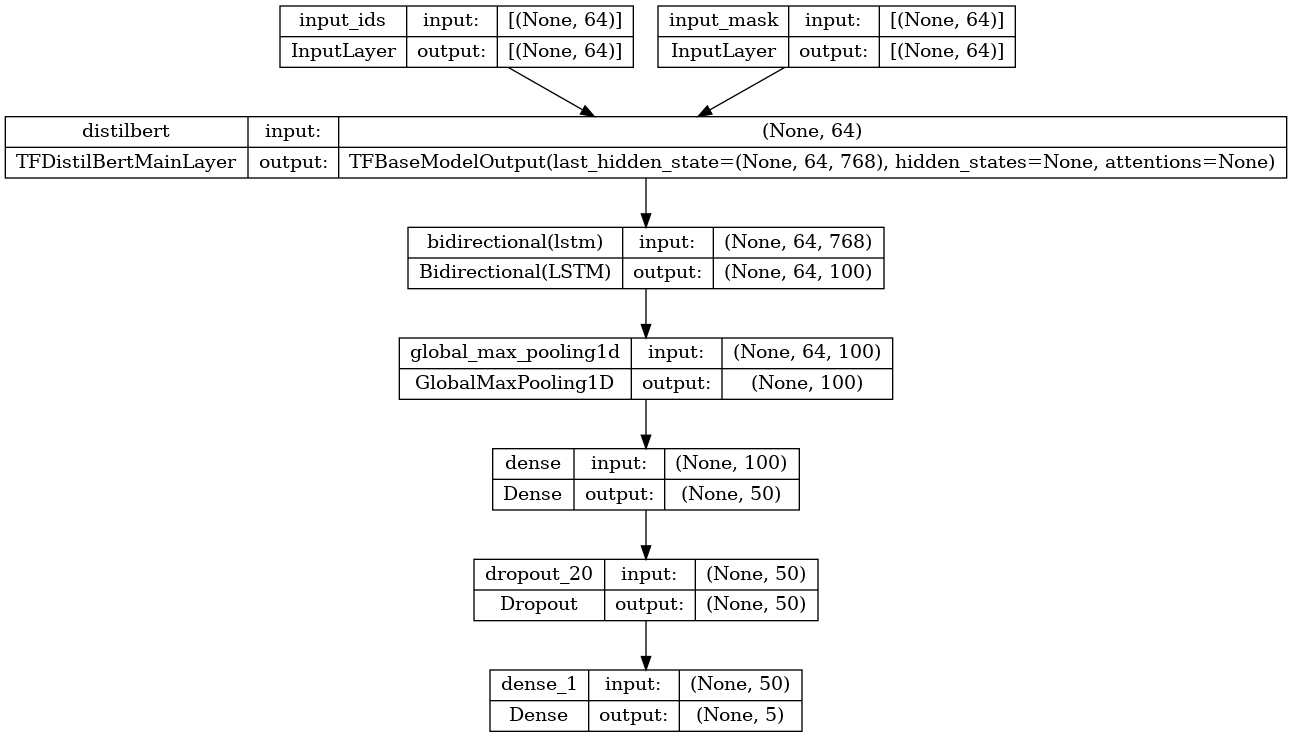

In [15]:
from tensorflow.keras.utils import plot_model
plot_model(model,show_shapes=True)

In [16]:
callbacks = []

log_dir = "./tmp/tensorboard/"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
callbacks.append(tensorboard_callback)

In [17]:
history = model.fit(
    train_dataset,
    shuffle=True,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_dataset,
    validation_steps=validation_steps,
    callbacks=callbacks,
)

2024-01-12 04:35:50.399199: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]
2024-01-12 04:35:50.400439: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]
/usr/local/lib/python3.10/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
2024-01-12 04:35:59.759

1/1 [==============================] - ETA: 0s - loss: 1.6188 - accuracy: 0.2500

2024-01-12 04:36:01.304439: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]
2024-01-12 04:36:01.304735: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]


1/1 [==============================] - 13s 13s/step - loss: 1.6188 - accuracy: 0.2500 - val_loss: 1.6563 - val_accuracy: 0.2500


In [18]:
epochs = 128
steps_per_epoch = 256
validation_steps = 32
test_steps = 32
freeze_bert_layer = True
learning_rate = 3e-5
epsilon = 1e-08
max_seq_length = 64

In [19]:
history = model.fit(
    train_dataset,
    shuffle=True,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_dataset,
    validation_steps=validation_steps,
    callbacks=callbacks,
)

Epoch 1/128
256/256 [==============================] - 103s 401ms/step - loss: 1.6138 - accuracy: 0.2217 - val_loss: 1.5878 - val_accuracy: 0.2578
Epoch 2/128
256/256 [==============================] - 102s 399ms/step - loss: 1.5880 - accuracy: 0.2598 - val_loss: 1.5664 - val_accuracy: 0.2969
Epoch 3/128
256/256 [==============================] - 102s 398ms/step - loss: 1.5713 - accuracy: 0.2705 - val_loss: 1.5505 - val_accuracy: 0.3008
Epoch 4/128
256/256 [==============================] - 104s 405ms/step - loss: 1.5358 - accuracy: 0.3359 - val_loss: 1.5258 - val_accuracy: 0.3281
Epoch 5/128
256/256 [==============================] - 105s 410ms/step - loss: 1.5058 - accuracy: 0.3398 - val_loss: 1.4868 - val_accuracy: 0.3594
Epoch 6/128
256/256 [==============================] - 102s 397ms/step - loss: 1.4617 - accuracy: 0.3887 - val_loss: 1.4452 - val_accuracy: 0.3945
Epoch 7/128
256/256 [==============================] - 104s 405ms/step - loss: 1.4262 - accuracy: 0.3901 - val_loss: 1

256/256 [==============================] - 102s 401ms/step - loss: 1.2237 - accuracy: 0.4634 - val_loss: 1.2032 - val_accuracy: 0.5117
Epoch 57/128
256/256 [==============================] - 103s 401ms/step - loss: 1.1999 - accuracy: 0.4688 - val_loss: 1.2125 - val_accuracy: 0.4961
Epoch 58/128
256/256 [==============================] - 103s 401ms/step - loss: 1.1939 - accuracy: 0.4775 - val_loss: 1.2001 - val_accuracy: 0.5156
Epoch 59/128
256/256 [==============================] - 101s 393ms/step - loss: 1.2014 - accuracy: 0.4448 - val_loss: 1.2144 - val_accuracy: 0.5000
Epoch 60/128
256/256 [==============================] - 102s 399ms/step - loss: 1.2102 - accuracy: 0.4658 - val_loss: 1.1851 - val_accuracy: 0.5312
Epoch 61/128
256/256 [==============================] - 100s 392ms/step - loss: 1.1968 - accuracy: 0.4678 - val_loss: 1.1936 - val_accuracy: 0.5117
Epoch 62/128
256/256 [==============================] - 102s 399ms/step - loss: 1.2237 - accuracy: 0.4585 - val_loss: 1.1900 

256/256 [==============================] - 105s 409ms/step - loss: 1.1736 - accuracy: 0.4932 - val_loss: 1.1788 - val_accuracy: 0.5312
Epoch 112/128
256/256 [==============================] - 101s 394ms/step - loss: 1.1614 - accuracy: 0.4824 - val_loss: 1.1682 - val_accuracy: 0.5195
Epoch 113/128
256/256 [==============================] - 103s 404ms/step - loss: 1.1490 - accuracy: 0.4961 - val_loss: 1.1888 - val_accuracy: 0.5195
Epoch 114/128
256/256 [==============================] - 103s 401ms/step - loss: 1.1798 - accuracy: 0.4902 - val_loss: 1.1711 - val_accuracy: 0.5117
Epoch 115/128
256/256 [==============================] - 105s 411ms/step - loss: 1.1696 - accuracy: 0.4834 - val_loss: 1.1904 - val_accuracy: 0.5195
Epoch 116/128
256/256 [==============================] - 104s 406ms/step - loss: 1.1560 - accuracy: 0.4883 - val_loss: 1.1721 - val_accuracy: 0.5469
Epoch 117/128
256/256 [==============================] - 104s 405ms/step - loss: 1.1879 - accuracy: 0.4795 - val_loss: 1

In [20]:
print(history.history)

{'loss': [1.6137738227844238, 1.5879648923873901, 1.5713478326797485, 1.535779595375061, 1.5058115720748901, 1.4617081880569458, 1.4262468814849854, 1.4204281568527222, 1.3527144193649292, 1.3461445569992065, 1.3338370323181152, 1.3186949491500854, 1.3120421171188354, 1.3125203847885132, 1.3153367042541504, 1.3100059032440186, 1.280268907546997, 1.257287621498108, 1.2586884498596191, 1.2702689170837402, 1.2815366983413696, 1.2504820823669434, 1.2639994621276855, 1.2455083131790161, 1.266219139099121, 1.2456319332122803, 1.2381129264831543, 1.2604995965957642, 1.2414319515228271, 1.262345314025879, 1.2199218273162842, 1.2567719221115112, 1.2471872568130493, 1.2392545938491821, 1.2658798694610596, 1.251334547996521, 1.244325041770935, 1.2363041639328003, 1.2606284618377686, 1.233469843864441, 1.239277958869934, 1.2086727619171143, 1.219190239906311, 1.2392925024032593, 1.211248755455017, 1.2219769954681396, 1.2230757474899292, 1.224228024482727, 1.2336241006851196, 1.2108111381530762, 1.

In [21]:
import pandas as pd
import numpy as np

from transformers import DistilBertTokenizer

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

def predict(text):
    encode_plus_tokens = tokenizer.encode_plus(
                            text,
                            pad_to_max_length=True,
                            max_length=max_seq_length,
                            truncation=True,
                            return_tensors='tf')
    
    input_ids = encode_plus_tokens['input_ids']
    input_mask = encode_plus_tokens['attention_mask']
    
    outputs = model.predict(x=(input_ids,input_mask))
    
    prediction = [{"label":config.id2label[item.argmax()], \
                   "socre":item.max().item()} for item in outputs]

    return prediction[0]

In [22]:
# Adhoc predict

In [23]:
predict("This is great!")

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2618: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


1/1 [==============================] - 2s 2s/step


{'label': 5, 'socre': 0.8526468873023987}

In [24]:
predict("This is cool.")

1/1 [==============================] - 0s 57ms/step


{'label': 5, 'socre': 0.44637617468833923}

In [25]:
predict("I don't like this.")

1/1 [==============================] - 0s 59ms/step


{'label': 1, 'socre': 0.4388291537761688}

In [26]:
predict("I might buy it again.")

1/1 [==============================] - 0s 66ms/step


{'label': 3, 'socre': 0.3731427788734436}

In [27]:
predict("The color is a little bit different from the picture. But it is OK.")

1/1 [==============================] - 0s 65ms/step


{'label': 3, 'socre': 0.6074767708778381}

In [28]:
def plot_accracy(history):
    import matplotlib.pyplot as plt

    # Setting Parameters
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    # 1) Accracy Plt
    plt.plot(epochs, acc, 'bo' ,label = 'training accuracy')
    plt.plot(epochs, val_acc, 'b' , label= 'validation accuracy')
    plt.title('Training and Validation acc')
    plt.legend()

    plt.figure()

    # 2) Loss Plt
    plt.plot(epochs, loss, 'bo' ,label = 'training loss')
    plt.plot(epochs, val_loss, 'b' , label= 'validation loss')
    plt.title('Training and Validation loss')
    plt.legend()

    plt.show()

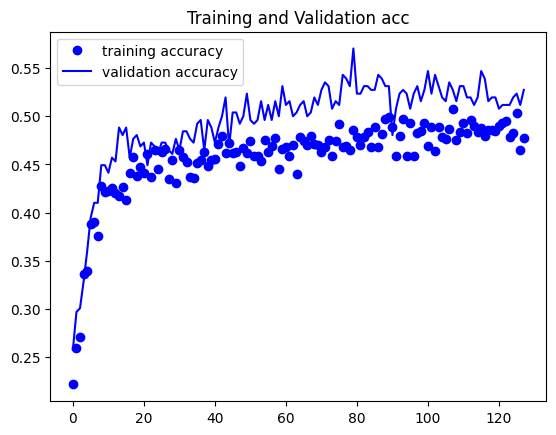

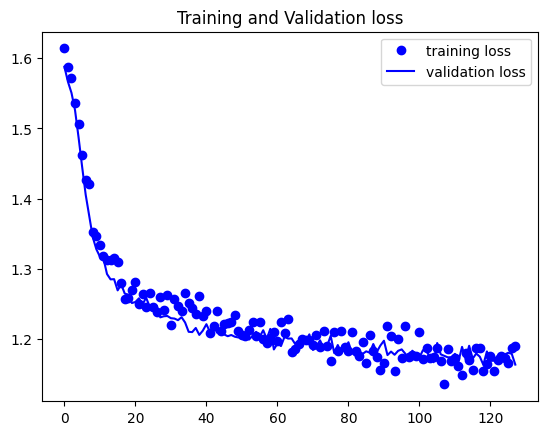

In [29]:
from keras import models 
from keras import layers
from keras import optimizers

#show Accuracy and Loss History
#「loss」と「val_loss」の違いですが、「loss」は学習時のlossの値で、正解と予測の差分です。この値を少なくするように学習を進めます。
#「val_loss」は検証用データでlossを計算した値です。
# モデルは「loss」の値を少なくするように学習データを使用して学習を進めます。ただし学習データのみを使用して学習するため、学習データのみ 
# にあてはまり新たなデータでうまく予測できなくなる、いわゆるオーバーフィッティング状態になることがあります。
# グラフ上では「loss」が下がっていくのに「val_loss」が上がってしまう状態です。
plot_accracy(history)

In [30]:
df = pd.read_parquet("/mnt/amazon_reviews_2015.snappy.parquet",columns=["star_rating","review_id","review_body"])

In [31]:
for i in range(1,6):
    new_df = 'df' + str(i)
    globals()[new_df] = df[df['star_rating'] == i].sample(n=200)

In [32]:
test_df = pd.concat([df1,df2,df3,df4,df5])

In [33]:
test_df.count()

star_rating    1000
review_id      1000
review_body    1000
dtype: int64

In [34]:
test_df['review_id'] = test_df['review_id'].str.decode("utf-8")

In [35]:
test_df['review_body'] = test_df['review_body'].str.decode("utf-8","ignore")

In [36]:
test_df

,star_rating,review_id,review_body
21493498,1,R30KTDKYZCFQCI,I ordered a 4/5 for my daughter who is skinny ...
7846906,1,R7P1AWG79105L,Did NOT run on my 2012 Nexus 7. Crashed every ...
35208751,1,R1XZ7LA5ZL0PUU,"This paper either passed an expiration date, o..."
18157817,1,R1KLVH68PUZI3J,wrote the names on the stakes and the first ra...
6019850,1,R28Q7FBE00NZZN,This was by far one of the worst things that I...
...,...,...,...
9464237,5,R32S5O2C0B09O1,Haven't heard a mouse since plugging these in!...
26304213,5,R3U4GAZVT56JL3,Awesome chopsticks. They are made of nice soli...
10459577,5,R168QA0ODMK8BO,"Pretty, does the job and affordable."
6784743,5,R1DWD6WH8W3CYL,"I loved the book. What a great romance , lots ..."


In [37]:
y_test = test_df['review_body'].map(predict)
y_true = test_df['star_rating']

1/1 [==============================] - 0s 60ms/step


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2618: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


1/1 [==============================] - 0s 58ms/step


1/1 [==============================] - 0s 56ms/step


1/1 [==============================] - 0s 60ms/step


1/1 [==============================] - 0s 58ms/step


1/1 [==============================] - 0s 57ms/step


1/1 [==============================] - 0s 59ms/step


1/1 [==============================] - 0s 60ms/step


In [38]:
print(type(y_test))
y_test2 = [x.get('label') for x in y_test.values]

<class 'pandas.core.series.Series'>


In [39]:
print(type(y_test2))
print(y_test2)

<class 'list'>
[1, 1, 1, 1, 1, 1, 1, 2, 3, 2, 1, 1, 1, 1, 1, 2, 2, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 2, 2, 2, 1, 3, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 2, 2, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 5, 2, 1, 1, 1, 2, 1, 1, 3, 2, 2, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 2, 5, 1, 1, 1, 1, 1, 4, 1, 1, 2, 1, 1, 2, 2, 1, 2, 5, 1, 2, 2, 1, 1, 4, 1, 1, 1, 4, 1, 1, 2, 1, 1, 2, 3, 3, 1, 1, 1, 1, 1, 1, 3, 1, 5, 3, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 3, 2, 1, 2, 1, 1, 1, 1, 2, 2, 3, 1, 1, 2, 5, 1, 3, 2, 1, 2, 1, 1, 3, 2, 3, 2, 2, 1, 2, 2, 2, 1, 2, 1, 2, 3, 1, 2, 2, 3, 1, 2, 1, 2, 4, 2, 2, 2, 2, 1, 3, 1, 1, 5, 1, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 1, 2, 1, 5, 2, 2, 2, 1, 2, 2, 1, 2, 1, 2, 2, 2, 1, 2, 5, 2, 2, 2, 3, 1, 2, 2, 2, 3, 3, 1, 3, 2, 2, 3, 2, 3, 1, 2, 4, 3, 1, 1, 3, 3, 3, 1, 3, 2, 3, 2, 4, 1, 2, 1, 2, 5, 1, 2, 2, 2, 2, 2, 1, 4, 2, 5, 2, 2, 1, 1, 3, 3, 2, 1, 3, 1, 1, 3, 3, 

In [40]:
print(type(y_true))
y_true2 = [x for x in y_true.values]

<class 'pandas.core.series.Series'>


In [41]:
print(type(y_true2))
print(y_true2)

<class 'list'>
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 

In [42]:
!pip uninstall -y matplotlib

Found existing installation: matplotlib 3.8.2
Uninstalling matplotlib-3.8.2:
  Successfully uninstalled matplotlib-3.8.2


In [43]:
!pip install matplotlib==3.7.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 63.0 MB/s eta 0:00:0000:010:01


In [ ]:
#!pip install seaborn==0.12.2

In [44]:
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#print(CLASSES)
cm = confusion_matrix(y_test2, y_true2, labels=CLASSES)
cm

array([[128,  60,  16,   9,   7],
       [ 53,  93,  60,  17,   5],
       [ 11,  34,  81,  47,   8],
       [  3,   7,  32,  74,  50],
       [  5,   6,  11,  53, 130]])

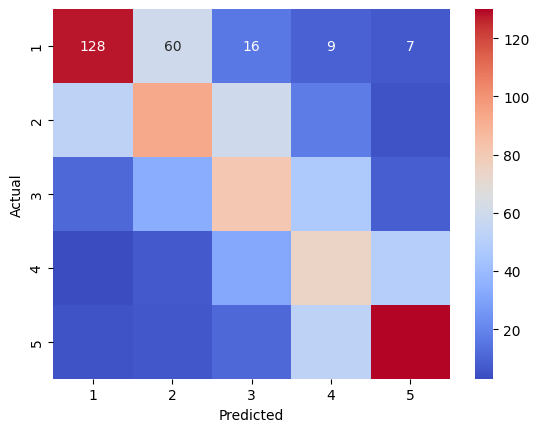

In [45]:
sns.heatmap(cm, annot=True, cmap='coolwarm', fmt='d', xticklabels=CLASSES, yticklabels=CLASSES)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [46]:
model.save('/mnt/tensorflow/',save_format='tf')

2024-01-12 08:24:10.989639: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'while/Placeholder_2' with dtype float and shape [?,50]
	 [[{{node while/Placeholder_2}}]]
2024-01-12 08:24:11.084425: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'while/Placeholder_2' with dtype float and shape [?,50]
	 [[{{node while/Placeholder_2}}]]
2024-01-12 08:24:11.114429: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and sh

2024-01-12 08:24:15.495063: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64,768]
	 [[{{node inputs}}]]
2024-01-12 08:24:15.510741: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64,768]
	 [[{{node inputs}}]]
2024-01-12 08:24:15.527240: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,50]
	 [[{{node inputs}}]]
2024-01-12 

INFO:tensorflow:Assets written to: /mnt/tensorflow/assets


INFO:tensorflow:Assets written to: /mnt/tensorflow/assets


In [47]:
!ls -l /mnt/tensorflow

total 4912
drwxr-xr-x 2 root root    4096 Jan  9 10:42 assets
-rw-r--r-- 1 root root      56 Jan 12 08:24 fingerprint.pb
-rw-r--r-- 1 root root   98619 Jan 12 08:24 keras_metadata.pb
-rw-r--r-- 1 root root 4914311 Jan 12 08:24 saved_model.pb
drwxr-xr-x 2 root root    4096 Jan 12 08:24 variables


In [ ]:
%%html

<p><b>Shutting down your kernel for this notebook to release resources.</b></p>
<button class="sm-command-button" data-commandlinker-command="kernelmenu:shutdown" style="display:none;">Shutdown Kernel</button>
        
<script>
try {
    els = document.getElementsByClassName("sm-command-button");
    els[0].click();
}
catch(err) {
    // NoOp
}    
</script>